In [1]:
from functools import partial
from pathlib import Path

import colorcet as cc
import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as scspatial
from dynamical_systems.continuous import Lorenz63
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.data.loaders import (
    MiniBatching,
    RandomSampleBatching,
)
from dynamics_discovery.models import NeuralODE, ODEModel
from dynamics_discovery.neighborhood import (
    AdjacencyMatrix,
    NeighborhoodMSELoss,
    NeighborhoodSegmentLoader,
    NeuralNeighborhoodFlow,
    sample_neighbor_inds,
)
from einops import rearrange
from jaxtyping import Array, Float
from matplotlib_utils.plots import colored_scatterplot
from ott.utils import batched_vmap
from tqdm import tqdm


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

Consider a state vector $\boldsymbol{x}\in \mathbb{R}^d$ whose dynamics is governed by the ODE
\begin{equation}
\frac{d\boldsymbol{x}}{dt} = f(\boldsymbol{x}).
\end{equation}

The evolution of small deviations $\boldsymbol{\delta x}(t) \in \mathbb{R}^d$ around $\boldsymbol{x}(t)$ is described by the variational equation:
\begin{equation}
\frac{d\boldsymbol{\delta x}}{dt} = \nabla_{\boldsymbol{x}}f(\boldsymbol{x}(t))\boldsymbol{\delta x} = J(\boldsymbol{x})\boldsymbol{\delta x}.
\end{equation}

As this equation is linear with respect to $\boldsymbol{\delta x}$, we can instead consider the following matrix differential equation
\begin{equation}
\frac{d\boldsymbol{M}}{dt} = J(\boldsymbol{x})\boldsymbol{M}, \; \boldsymbol{M}(t=0) = \boldsymbol{I}
\end{equation}
where $\boldsymbol{M}(t;\boldsymbol{x})\in \mathbb{R}^{d\times d}$ is the tangent evolution matrix (or operator), and $\boldsymbol{I}$ is the $d\times d$ identity matrix.

In the vincinity of $\boldsymbol{x}(t)$, the tangent evolution matrix linearly maps the perturbations forward in time:
\begin{equation}
\boldsymbol{\delta x}(t+\tau) = \boldsymbol{M}(\tau;\boldsymbol{x}(t))\boldsymbol{\delta x}(t).
\end{equation}

Thus, when the number of deviations to forecast $m$ is larger than $d$, it is more economical to compute the tangent evolution matrix instead of directly solving the variational equation for the individual perturbations.

In [4]:
noise = 0.05
downsample = 40  # 2
dataset, transform = (
    TimeSeriesDataset(
        *TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")[::100]
    )
    .downsample(downsample)
    # .split_along_time(2000)[0]
    .split_along_time(500)[0]
    .add_noise(noise)
    .standardize()
)

lorenz_scaled = TransformedODE(Lorenz63(), transform)

dataset.u.shape

(50, 250, 3)

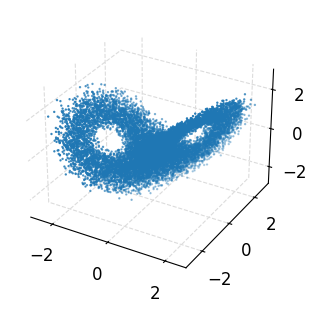

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), subplot_kw={"projection": "3d"})
ax.scatter(*dataset.u.reshape(-1, 3).T, s=0.5)

## Find neighbors in the range $[r_{min}, r_{max}]$

In [6]:
r_min, r_max = 0.4, 0.6
rollout = 3

tree = scspatial.KDTree(
    rearrange(dataset.u[:, :-rollout], "traj time dim -> (traj time) dim")
)


distance_matrix = tree.sparse_distance_matrix(tree, r_max)
within_range = distance_matrix >= r_min

In [7]:
neighbor_inds = []
for i in tqdm(range(within_range.shape[0])):
    neighbor_inds.append(
        within_range.indices[within_range.indptr[i] : within_range.indptr[i + 1]]
    )

100%|██████████| 12350/12350 [00:00<00:00, 1319165.06it/s]


(array([  34.,  122.,  246.,  317.,  356.,  421.,  562.,  652.,  922.,
        1714., 1925., 1498., 1250., 1039.,  934.,  829.,  631.,  585.,
         538.,  473.,  424.,  372.,  365.,  365.,  346.,  363.,  396.,
         335.,  331.,  359.,  352.,  297.,  302.,  347.,  353.,  348.,
         322.,  323.,  327.,  380.,  369.,  404.,  389.,  316.,  280.,
         269.,  335.,  325.,  101.,    7.]),
 array([  29.  ,   70.26,  111.52,  152.78,  194.04,  235.3 ,  276.56,
         317.82,  359.08,  400.34,  441.6 ,  482.86,  524.12,  565.38,
         606.64,  647.9 ,  689.16,  730.42,  771.68,  812.94,  854.2 ,
         895.46,  936.72,  977.98, 1019.24, 1060.5 , 1101.76, 1143.02,
        1184.28, 1225.54, 1266.8 , 1308.06, 1349.32, 1390.58, 1431.84,
        1473.1 , 1514.36, 1555.62, 1596.88, 1638.14, 1679.4 , 1720.66,
        1761.92, 1803.18, 1844.44, 1885.7 , 1926.96, 1968.22, 2009.48,
        2050.74, 2092.  ]),
 <BarContainer object of 50 artists>)

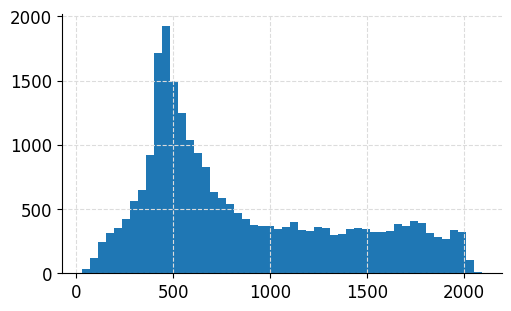

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(np.asarray([len(idx) for idx in neighbor_inds]), bins=50)

Sufficient number of neighbors present: True


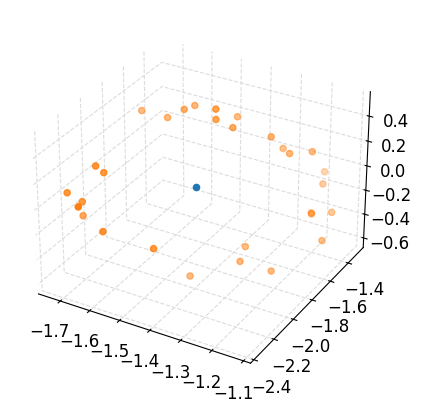

In [7]:
adjacency = AdjacencyMatrix(within_range.indptr, within_range.indices)
sample_ind = 50
neighbor_inds, sufficient = sample_neighbor_inds(sample_ind, adjacency, 30, 30)
print(f"Sufficient number of neighbors present: {sufficient}")

fig, ax = plt.subplots(1, 1, figsize=(5, 4), subplot_kw={"projection": "3d"})

idx_center = np.divmod(sample_ind, dataset.u.shape[1] - rollout)
idx_neighbors = np.divmod(neighbor_inds, dataset.u.shape[1] - rollout)

ax.scatter(*dataset.u[idx_center].T)
ax.scatter(*dataset.u[idx_neighbors].T)

In [8]:
neighbor_traj_length = 4
model = ODEModel(TransformedODE(Lorenz63(), transform))
neighborflow = NeuralNeighborhoodFlow(model, second_order=True)

sol = neighborflow.solve(
    dataset.t[0, :neighbor_traj_length],
    (dataset.u[idx_center], dataset.u[idx_neighbors] - dataset.u[idx_center]),
)

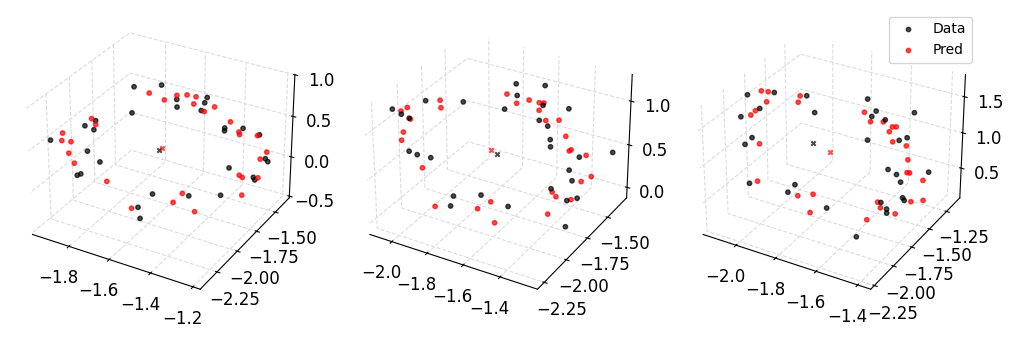

In [9]:
fig, axes = plt.subplots(
    1, neighbor_traj_length - 1, figsize=(10, 4), subplot_kw={"projection": "3d"}
)
scatter_kwargs = {"s": 10, "alpha": 0.7}

for i in range(neighbor_traj_length - 1):
    axes[i].scatter(
        *dataset.u[idx_neighbors[0], idx_neighbors[1] + i + 1].T,
        color="black",
        label="Data",
        **scatter_kwargs,
    )
    axes[i].scatter(
        *dataset.u[idx_center[0], idx_center[1] + i + 1].T,
        color="black",
        marker="x",
        **scatter_kwargs,
    )
    axes[i].scatter(
        *(sol[1][i + 1] + sol[0][i + 1]).T, color="red", label="Pred", **scatter_kwargs
    )
    axes[i].scatter(*sol[0][i + 1].T, color="red", marker="x", **scatter_kwargs)
axes[-1].legend(fontsize="small")

## Instantiate data loader and inspect loss values for the ground truth ODE and an uninitialized neural ODE

In [8]:
loader = NeighborhoodSegmentLoader(
    dataset,
    segment_length=2,
    r_min=0.6,
    r_max=0.8,
    num_neighbors=30,
    neighbor_cutoff=30,
    batch_strategy=RandomSampleBatching(2048),
)

In [9]:
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)
batch[2].shape

(2048, 2, 30, 3)

In [10]:
batch[2].shape

(2048, 2, 30, 3)

In [11]:
t_batch, u_batch, u_nn_batch, nn_mask = batch

neighbor_traj_length = 5
model = ODEModel(TransformedODE(Lorenz63(), transform))
model_nn = NeuralODE(dim=3, width=64, depth=3)
neighborflow = NeuralNeighborhoodFlow(model, second_order=True)
neighborflow_nn = NeuralNeighborhoodFlow(model_nn, second_order=True)

sol = eqx.filter_vmap(neighborflow.solve)(
    t_batch[:, :neighbor_traj_length],
    (u_batch[:, 0], u_nn_batch[:, 0] - jnp.expand_dims(u_batch[:, 0], -2)),
)

sol_nn = eqx.filter_vmap(neighborflow_nn.solve)(
    t_batch[:, :neighbor_traj_length],
    (u_batch[:, 0], u_nn_batch[:, 0] - jnp.expand_dims(u_batch[:, 0], -2)),
)

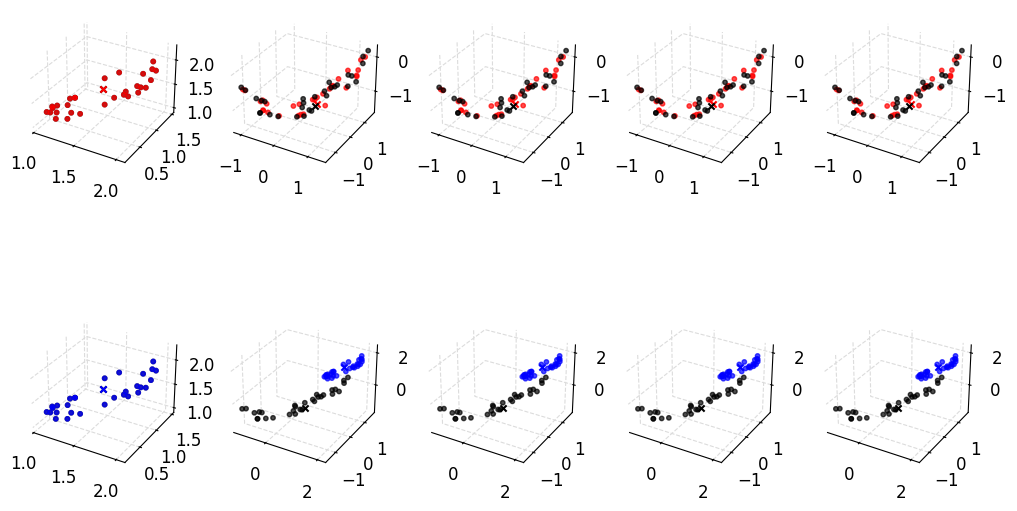

In [12]:
fig, axes = plt.subplots(
    2,
    neighbor_traj_length,
    figsize=(10, 6),
    subplot_kw={"projection": "3d"},
    constrained_layout=True,
)
scatter_kwargs = {"s": 10, "alpha": 0.7}


sample_ind = 20
for i in range(neighbor_traj_length):
    axes[0, i].scatter(
        *u_nn_batch[sample_ind, i].T,
        color="black",
        label="Data",
        **scatter_kwargs,
    )
    axes[0, i].scatter(*u_batch[sample_ind, i].T, color="black", marker="x", s=20)
    axes[0, i].scatter(
        *(sol[1][sample_ind, i] + sol[0][sample_ind, i]).T,
        color="red",
        label="Pred",
        **scatter_kwargs,
    )
    axes[0, i].scatter(*sol[0][sample_ind, i].T, color="red", marker="x", s=20)
    axes[1, i].scatter(
        *u_nn_batch[sample_ind, i].T,
        color="black",
        label="Data",
        **scatter_kwargs,
    )
    axes[1, i].scatter(*u_batch[sample_ind, i].T, color="black", marker="x", s=20)
    axes[1, i].scatter(
        *(sol_nn[1][sample_ind, i] + sol_nn[0][sample_ind, i]).T,
        color="blue",
        label="Pred",
        **scatter_kwargs,
    )
    axes[1, i].scatter(*sol_nn[0][sample_ind, i].T, color="blue", marker="x", s=20)
# axes[0, -1].legend(fontsize="small")

In [13]:
from dynamical_systems.metrics.measure_distances import maximum_mean_discrepancy


mmd = jnp.mean(
    jax.vmap(jax.vmap(maximum_mean_discrepancy))(
        (sol[1] + jnp.expand_dims(sol[0], 2)),
        u_nn_batch[:, :neighbor_traj_length],
    )[:, 1:]
)
mmd_nn = jnp.mean(
    jax.vmap(jax.vmap(maximum_mean_discrepancy))(
        (sol_nn[1] + jnp.expand_dims(sol_nn[0], 2)),
        u_nn_batch[:, :neighbor_traj_length],
    )[:, 1:]
)
print(f"ODE: {mmd}, Neural ODE: {mmd_nn}")

ODE: 0.23345469421674625, Neural ODE: 1.4885216962162664


In [14]:
neighborflow = NeuralNeighborhoodFlow(model, second_order=True)
sol_nn = eqx.filter_vmap(neighborflow.solve)(
    t_batch[:, :neighbor_traj_length],
    (u_batch[:, 0], u_nn_batch[:, 0] - jnp.expand_dims(u_batch[:, 0], -2)),
)

In [15]:
loss_fn = NeighborhoodMSELoss(neighbor_traj_length=2)
print(f"Ground truth ODE: {jax.tree.map(lambda x: x.item(), loss_fn(model, batch))}")
print(
    f"Untrained neural ODE: {jax.tree.map(lambda x: x.item(), loss_fn(model_nn, batch))}"
)

Ground truth ODE: (0.049233702293034726, {'mse': 0.04551976998023588, 'mse_neighbors': 0.049233702293034726})
Untrained neural ODE: (1.0410097635630808, {'mse': 1.0839636718043686, 'mse_neighbors': 1.0410097635630808})


In [ ]:
@jax.jit
@partial(batched_vmap, batch_size=2, in_axes=(None, 0, 0))
@partial(jax.vmap, in_axes=(None, 0, 0))
def loss_from_params(sigma, beta, rho):
    ode = Lorenz63(sigma, beta, rho)
    model = ODEModel(TransformedODE(ode, transform))
    return loss_fn(model, batch)[1]


beta_grid, rho_grid = jnp.meshgrid(
    jnp.linspace(0, 5.0, 100), jnp.linspace(0.0, 60.0, 100)
)
loss_array = loss_from_params(10.0, beta_grid, rho_grid)

Text(0.5, 0.98, 'Noise = 0.1, Neighborhood rollout = 4')

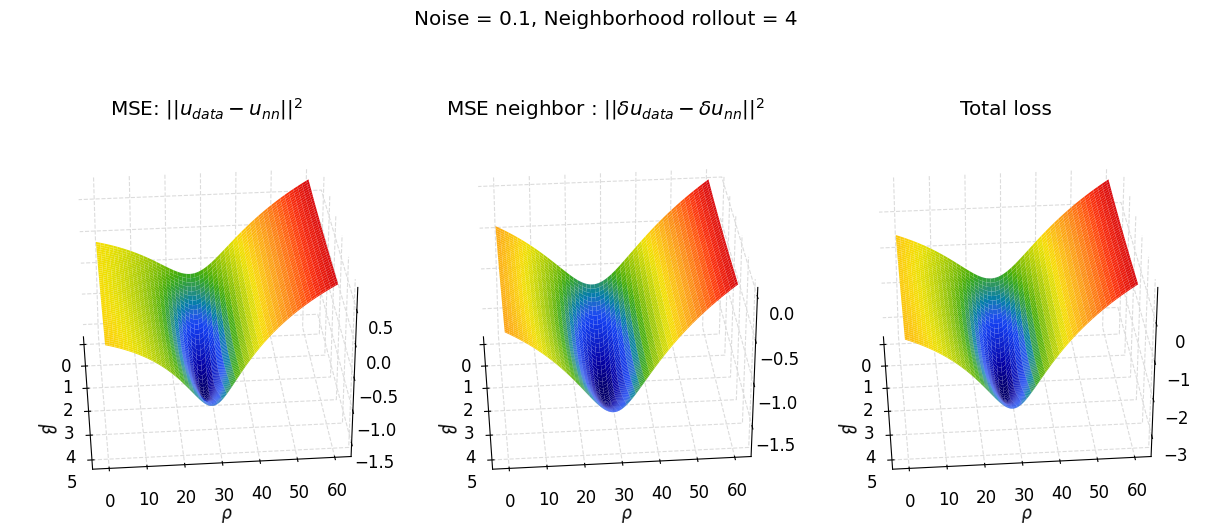

In [54]:
fig, axes = plt.subplots(
    1, 3, figsize=(12, 6), sharex=True, subplot_kw={"projection": "3d"}
)
values = [
    np.log10(loss_array["mse"]),
    np.log10(loss_array["mse_neighbors"]),
    np.log10(loss_array["mse"]) + np.log10(loss_array["mse_neighbors"]),
]

for ax, v in zip(axes, values):
    plot = ax.plot_surface(
        beta_grid,
        rho_grid,
        v,
        cmap=cc.cm.rainbow4,
    )
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
    # fig.colorbar(plot, cax=cax, orientation="vertical", shrink=0.3)

    ax.view_init(azim=-5)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\rho$")
axes[0].set_title(r"MSE: $||u_{data}-u_{nn}||^2$")
axes[1].set_title(r"MSE neighbor : $||\delta u_{data}-\delta u_{nn}||^2$")
axes[2].set_title(r"Total loss")

fig.suptitle(
    f"Noise = {noise}, Neighborhood rollout = {4}",
    fontsize="large",
)

## Lorenz 96

In [ ]:
from functools import partial
from pathlib import Path

import colorcet as cc
import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as scspatial
from dynamical_systems.continuous import Lorenz96
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.data.loaders import (
    MiniBatching,
    RandomSampleBatching,
)
from dynamics_discovery.models import NeuralODE, ODEModel
from dynamics_discovery.neighborhood import (
    AdjacencyMatrix,
    NeighborhoodMSELoss,
    NeighborhoodSegmentLoader,
    NeuralNeighborhoodFlow,
    sample_neighbor_inds,
)
from einops import rearrange
from jaxtyping import Array, Float
from matplotlib_utils.plots import colored_scatterplot
from ott.utils import batched_vmap
from tqdm import tqdm


jax.config.update("jax_default_device", jax.devices("gpu")[2])
jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

In [40]:
noise = 0.0
downsample = 2
dataset, transform = (
    TimeSeriesDataset(
        *TimeSeriesDataset.from_hdf5(datadir / "lorenz96_train.hdf5")[::100]
    )
    .downsample(downsample)
    .split_along_time(500)[0]
    .add_noise(noise)
    .standardize()
)

lorenz_scaled = TransformedODE(Lorenz96(), transform)

dataset.u.shape

(50, 500, 6)

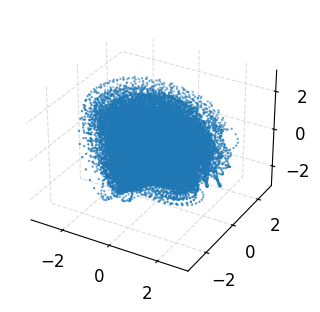

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), subplot_kw={"projection": "3d"})
ax.scatter(*dataset.u[..., :3].reshape(-1, 3).T, s=0.5)

In [ ]:
from math import sqrt


loader = NeighborhoodSegmentLoader(
    dataset,
    segment_length=10,
    r_min=0.6 * sqrt(2),
    r_max=0.8 * sqrt(8),
    num_neighbors=60,
    neighbor_cutoff=60,
    batch_strategy=RandomSampleBatching(2048),
)

In [43]:
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)
batch[2].shape

(2048, 10, 60, 6)

In [44]:
t_batch, u_batch, u_nn_batch, nn_mask = batch

neighbor_traj_length = 10
model = ODEModel(TransformedODE(Lorenz96(), transform))
model_nn = NeuralODE(dim=6, width=64, depth=6)
neighborflow = NeuralNeighborhoodFlow(model, second_order=True)
neighborflow_nn = NeuralNeighborhoodFlow(model_nn, second_order=True)

sol = eqx.filter_vmap(neighborflow.solve)(
    t_batch[:, :neighbor_traj_length],
    (u_batch[:, 0], u_nn_batch[:, 0] - jnp.expand_dims(u_batch[:, 0], -2)),
)

sol_nn = eqx.filter_vmap(neighborflow_nn.solve)(
    t_batch[:, :neighbor_traj_length],
    (u_batch[:, 0], u_nn_batch[:, 0] - jnp.expand_dims(u_batch[:, 0], -2)),
)

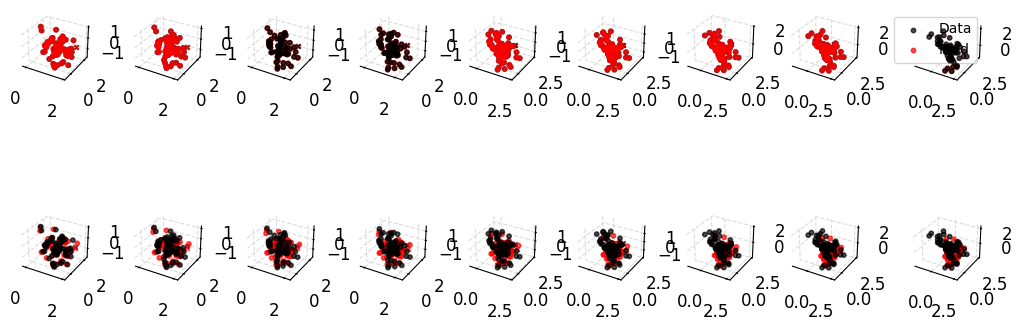

In [45]:
fig, axes = plt.subplots(
    2, neighbor_traj_length - 1, figsize=(10, 4), subplot_kw={"projection": "3d"}
)
scatter_kwargs = {"s": 10, "alpha": 0.7}


sample_ind = 20
for i in range(1, neighbor_traj_length):
    axes[0, i - 1].scatter(
        *u_nn_batch[sample_ind, i, :, :3].T,
        color="black",
        label="Data",
        **scatter_kwargs,
    )
    axes[0, i - 1].scatter(
        *u_batch[sample_ind, i, :3].T,
        color="black",
        marker="x",
        **scatter_kwargs,
    )
    axes[0, i - 1].scatter(
        *(sol[1][sample_ind, i] + sol[0][sample_ind, i])[..., :3].T,
        color="red",
        label="Pred",
        **scatter_kwargs,
    )
    axes[0, i - 1].scatter(
        *sol[0][sample_ind, i, :3].T, color="red", marker="x", **scatter_kwargs
    )
    axes[1, i - 1].scatter(
        *u_nn_batch[sample_ind, i, :, :3].T,
        color="black",
        label="Data",
        **scatter_kwargs,
    )
    axes[1, i - 1].scatter(
        *u_batch[sample_ind, i, :3].T,
        color="black",
        marker="x",
        **scatter_kwargs,
    )
    axes[1, i - 1].scatter(
        *(sol_nn[1][sample_ind, i] + sol_nn[0][sample_ind, i])[..., :3].T,
        color="red",
        label="Pred",
        **scatter_kwargs,
    )
    axes[1, i - 1].scatter(
        *sol_nn[0][sample_ind, i, :3].T, color="red", marker="x", **scatter_kwargs
    )
axes[0, -1].legend(fontsize="small")

In [46]:
loss_fn = NeighborhoodMSELoss(neighbor_traj_length=10)
print(f"Ground truth ODE: {loss_fn(model, batch)}")
print(f"Untrained neural ODE: {loss_fn(model_nn, batch)}")

Ground truth ODE: (Array(4.46133679e-10, dtype=float64), {'mse': Array(7.5334664e-11, dtype=float64), 'mse_neighbors': Array(3.70799015e-10, dtype=float64)})
Untrained neural ODE: (Array(0.52293874, dtype=float64), {'mse': Array(0.27708366, dtype=float64), 'mse_neighbors': Array(0.24585508, dtype=float64)})


## Prototype implementing the ConFIG method

In [ ]:
from dynamics_discovery.training.multiterm import filter_value_and_grad_ConFIG


loss_fn_multi = NeighborhoodMSELoss(multiterm=True)
model = NeuralNeighborhoodFlow(NeuralODE(3, 32, 3))

num_neighbors = 10
loader = NeighborhoodSegmentLoader(
    dataset, 2, num_neighbors, RandomSampleBatching(batch_size=2048)
)
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)

In [ ]:
config_grad_fn = filter_value_and_grad_ConFIG(loss_fn_multi, has_aux=True)

In [96]:
(loss, aux), grad_config = config_grad_fn(model, batch)
print(loss)
print(aux)
print(grad_config)

1.0615665930098708
{'mse': Array(1.06110904, dtype=float64), 'mse_neighbors': Array(0.00045755, dtype=float64)}
NeuralNeighborhoodFlow(
  ode=NeuralODE(
    net=MLP(
      layers=(
        Linear(
          weight=f64[32,3],
          bias=f64[32],
          in_features=3,
          out_features=32,
          use_bias=True
        ),
        Linear(
          weight=f64[32,32],
          bias=f64[32],
          in_features=32,
          out_features=32,
          use_bias=True
        ),
        Linear(
          weight=f64[32,32],
          bias=f64[32],
          in_features=32,
          out_features=32,
          use_bias=True
        ),
        Linear(
          weight=f64[3,32],
          bias=f64[3],
          in_features=32,
          out_features=3,
          use_bias=True
        )
      ),
      activation=None,
      final_activation=None,
      use_bias=True,
      use_final_bias=True,
      in_size=3,
      out_size=3,
      width_size=32,
      depth=3
    ),
    dim=3,


In [3]:
import numpy as np
from tqdm import tqdm


loader = NeighborhoodSegmentLoader(
    dataset,
    2,
    30,
    MiniBatching(batch_size=10000, permute_initial=False, drop_last=False),
)
loader_state = loader.init()

u_neighbors = []
for i in tqdm(range(loader.num_batches)):
    batch, loader_state = loader.load_batch(loader_state)
    u_neighbors.append(np.asarray(batch[2]))

100%|██████████| 125/125 [00:32<00:00,  3.84it/s]


In [6]:
u_neighbors[-2].shape

(10000, 2, 30, 3)

In [4]:
loader = NeighborhoodSegmentLoader(dataset, 2, 30, MiniBatching(batch_size=10000))
loader_state = loader.init()
loader_state

((Array([2052612, 4922476, 3295904, ...,  823700, 3925540, 1025065], dtype=int64),
  0,
  Array((), dtype=key<fry>) overlaying:
  [1797259609 2579123966]),)

In [5]:
jax.random.permutation(jax.random.key(0), 5)

Array([0, 1, 4, 3, 2], dtype=int64)

In [4]:
M_pred = eqx.filter_vmap(
    lambda u_i: tangent_evolution_matrix(
        lorenz_scaled, u_i, 0.0, t_train[n_steps - 1] - t_train[0]
    )
)(u_train[: -n_steps + 1])

In [5]:
import scipy.signal as scsignal


u_smooth = scsignal.savgol_filter(u_train, window_length=7, polyorder=3, axis=0)
u_smooth.shape

(10000, 3)

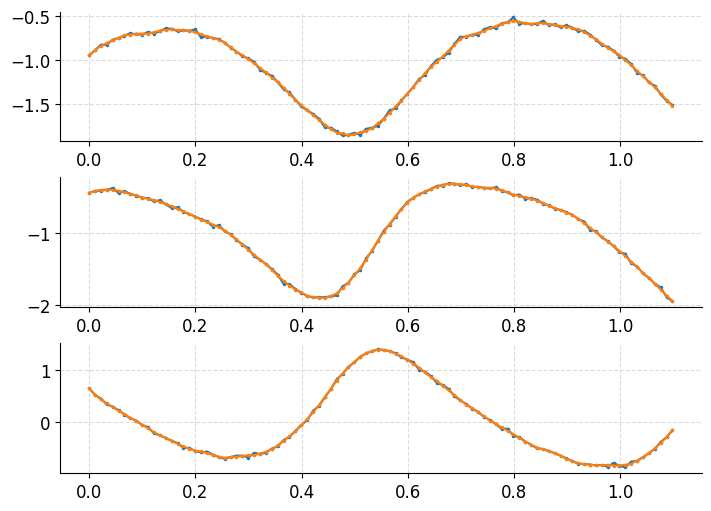

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(7, 5))
for i, ax in enumerate(axes):
    ax.plot(t_train[:100], u_train[:100, i], ".-")
    ax.plot(t_train[:100], u_smooth[:100, i], ".-")

In [7]:
_, _, du, _ = create_neighborhood_dataset(
    t_train,
    u_smooth,
    num_neighbors=30,
    train_length=n_steps,
    train_length_neighbors=n_steps,
    min_radius=0.2,
    max_radius=0.4,
)

In [8]:
du.shape

(9999, 2, 30, 3)

In [9]:
du0, du1 = du[:, 0], du[:, -1]

M_data = jnp.permute_dims((jnp.linalg.pinv(du0) @ du1).T, (2, 0, 1))

In [10]:
du0_test = du0[0]
du0_test.shape

(30, 3)

In [11]:
import itertools


def batched_outer(
    x: Float[Array, "*dims_x"], y: Float[Array, " dim_y"]
) -> Float[Array, "*dims_x dim_y"]:
    """Compute a (batched) outer product between a n(>1)D tensor x and a 1D tensor y.

    For x of shape (i_0, ..., i_{n-1}) and y of shape (j,), the output tensor has the
    shape (i_0, ..., i_{n-1}, j)."""
    return jnp.expand_dims(x, axis=-1) * y


def monomial_basis_unique(x, order: int):
    arr = jnp.asarray(list(itertools.combinations_with_replacement(x, order)))
    return jnp.prod(arr, axis=-1)


def make_monomial_features(x, max_order: int = 2):
    """Given a vector x=[x1,x2,x3], create a 1D vector containing all the monomial
    basis terms upto order n.

    For n=2, this corresponds to [x1, x2, x3, x1^2, x1x2, x1x3, x2x1, x2^2, x2x3, x3x1,
    x3x2, x3^2]"""
    terms = [monomial_basis_unique(x, i) for i in range(1, max_order + 1)]
    return jnp.concatenate(terms)

In [12]:
du0_second_order = jax.vmap(jax.vmap(lambda x: make_monomial_features(x, 3)))(du0)
du0_second_order.shape

(9999, 30, 19)

In [13]:
du0_second_order[0, 0]

Array([ 1.15314194e-01,  1.57277650e-01, -4.86175360e-02,  1.32973634e-02,
        1.81363455e-02, -5.60629199e-03,  2.47362592e-02, -7.64645181e-03,
        2.36366481e-03,  1.53337475e-03,  2.09137807e-03, -6.46485044e-04,
        2.85244180e-03, -8.81744430e-04,  2.72564103e-04,  3.89046072e-03,
       -1.20261597e-03,  3.71751646e-04, -1.14915559e-04], dtype=float64)

In [14]:
M_data2 = jnp.permute_dims((jnp.linalg.pinv(du0_second_order) @ du1).T, (2, 0, 1))[
    ..., :3
]
M_data2.shape

(9999, 3, 3)

In [15]:
err = jnp.linalg.norm(M_pred - M_data, axis=(-1, -2)) / jnp.linalg.norm(
    M_pred, axis=(-1, -2)
)
err2 = jnp.linalg.norm(M_pred - M_data2, axis=(-1, -2)) / jnp.linalg.norm(
    M_pred, axis=(-1, -2)
)

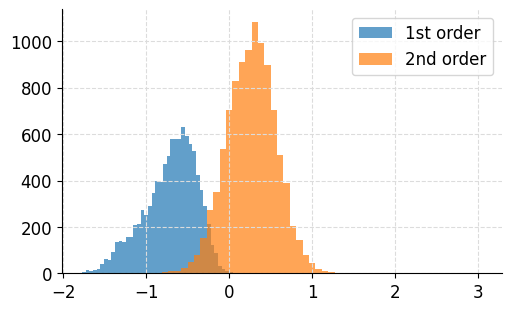

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(jnp.log10(err), bins=50, alpha=0.7, label="1st order")
ax.hist(jnp.log10(err2), bins=50, alpha=0.7, label="2nd order")
ax.legend()

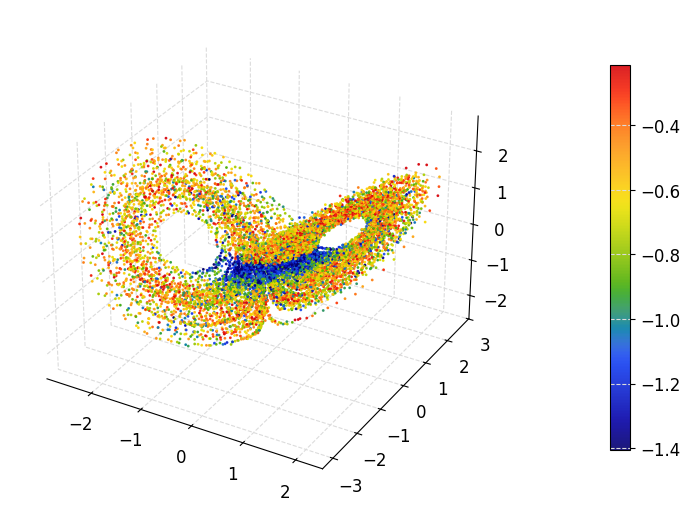

In [17]:
import colorcet as cc
import numpy as np


scatter_kwargs = {
    "s": 1,
    "cmap": cc.cm.rainbow4,
    "vmin": np.percentile(jnp.log10(err), 2.5),
    "vmax": np.percentile(jnp.log10(err), 97.5),
    "alpha": 0.9,
}

fig = colored_scatterplot(
    (u_train[: -n_steps + 1].T,), (jnp.log10(err),), **scatter_kwargs
)

In [ ]:
ode = NeuralODE(3, 32, 3, key=0, solver=dfx.Tsit5(), rtol=1e-4, atol=1e-6)
model = NeuralNeighborhoodFlow(ode, use_seminorm=False, second_order=False)

SyntaxError: positional argument follows keyword argument (2378072622.py, line 1)